<a href="https://colab.research.google.com/github/ZahraDehghani99/Parkinson-Disease-Classification/blob/main/parkinson_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parkinson's Disease Classification


## Read data and EDA

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read data set

In [3]:
data  = pd.read_csv('/content/drive/MyDrive/ML_Dr.sajedi/pd_speech_features.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


Each person has 3 records, so we have 252 patients.

In [ ]:
data.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,...,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,...,0.729330,0.780410,5.22940,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,...,0.269510,-0.005522,0.35054,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0.147370,...,0.366920,-0.492650,0.19164,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.3

In [ ]:
print(f'data shape : {data.shape}')

data shape : (756, 755)


In [ ]:
print(f'data columns type : \n{data.dtypes}')

data columns type : 
id                             int64
gender                         int64
PPE                          float64
DFA                          float64
RPDE                         float64
                              ...   
tqwt_kurtosisValue_dec_33    float64
tqwt_kurtosisValue_dec_34    float64
tqwt_kurtosisValue_dec_35    float64
tqwt_kurtosisValue_dec_36    float64
class                          int64
Length: 755, dtype: object


In [ ]:
print(f'number of unique values in each column : \n{data.nunique()}')

number of unique values in each column : 
id                           252
gender                         2
PPE                          740
DFA                          745
RPDE                         748
                            ... 
tqwt_kurtosisValue_dec_33    752
tqwt_kurtosisValue_dec_34    753
tqwt_kurtosisValue_dec_35    753
tqwt_kurtosisValue_dec_36    754
class                          2
Length: 755, dtype: int64


In [ ]:
data.isnull().sum()

id                           0
gender                       0
PPE                          0
DFA                          0
RPDE                         0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 755, dtype: int64

In [ ]:
print(f'number of null values in data : {data.isnull().sum().sum()}')

number of null values in data : 0


In [ ]:
data.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,756.00000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,0.000605,0.001159,0.001815,0.067473,0.60642,0.034375,0.041175,0.055366,0.103125,0.961508,0.051131,18.859632,70.828609,76.135371,73.997008,647.174519,1233.852088,2562.425251,3547.259244,213.363237,297.174077,536.821070,506.604856,0.904423,32.295832,4.454840,1.092503,0.215038,0.144832,...,-0.041840,-0.015615,-0.005242,1059.146612,377.357439,328.927860,317.994439,305.036007,172.362746,40.408662,15.064513,12.107316,11.757945,11.871530,9.529080,3.741615,3.332313,3.270290,2.995472,2.710678,2.608229,2.553457,2.432001,2.300006,2.183111,2.176542,2.595250,6.782668,15.766942,21.026054,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,0.000981,0.001677,0.002942,0.042969,0.38257,0.022366,0.027165,0.033939,0.067097,0.064095,0.104579,5.576473,8.858268,6.446451,7.018006,134.957916,169.090402,393.315598,347.864299,306.976045,450.125488,754.341717,658.326606,0.147826,31.140746,7.313057,0.350789,0.132549,0.060065,...,1.431979,1.451535,4.448635,3522.528562,1514.808488,1338.602187,1275.228777,1211.296576,821.740615,239.548628,75.865176,77.370230,74.594974,39.125733,36.349168,4.821202,2.962967,2.049877,1.444227,1.310653,1.229086,1.061068,0.892523,0.868506,0.796446,1.709860,5.979131,31.707014,45.247304,43.716898,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,

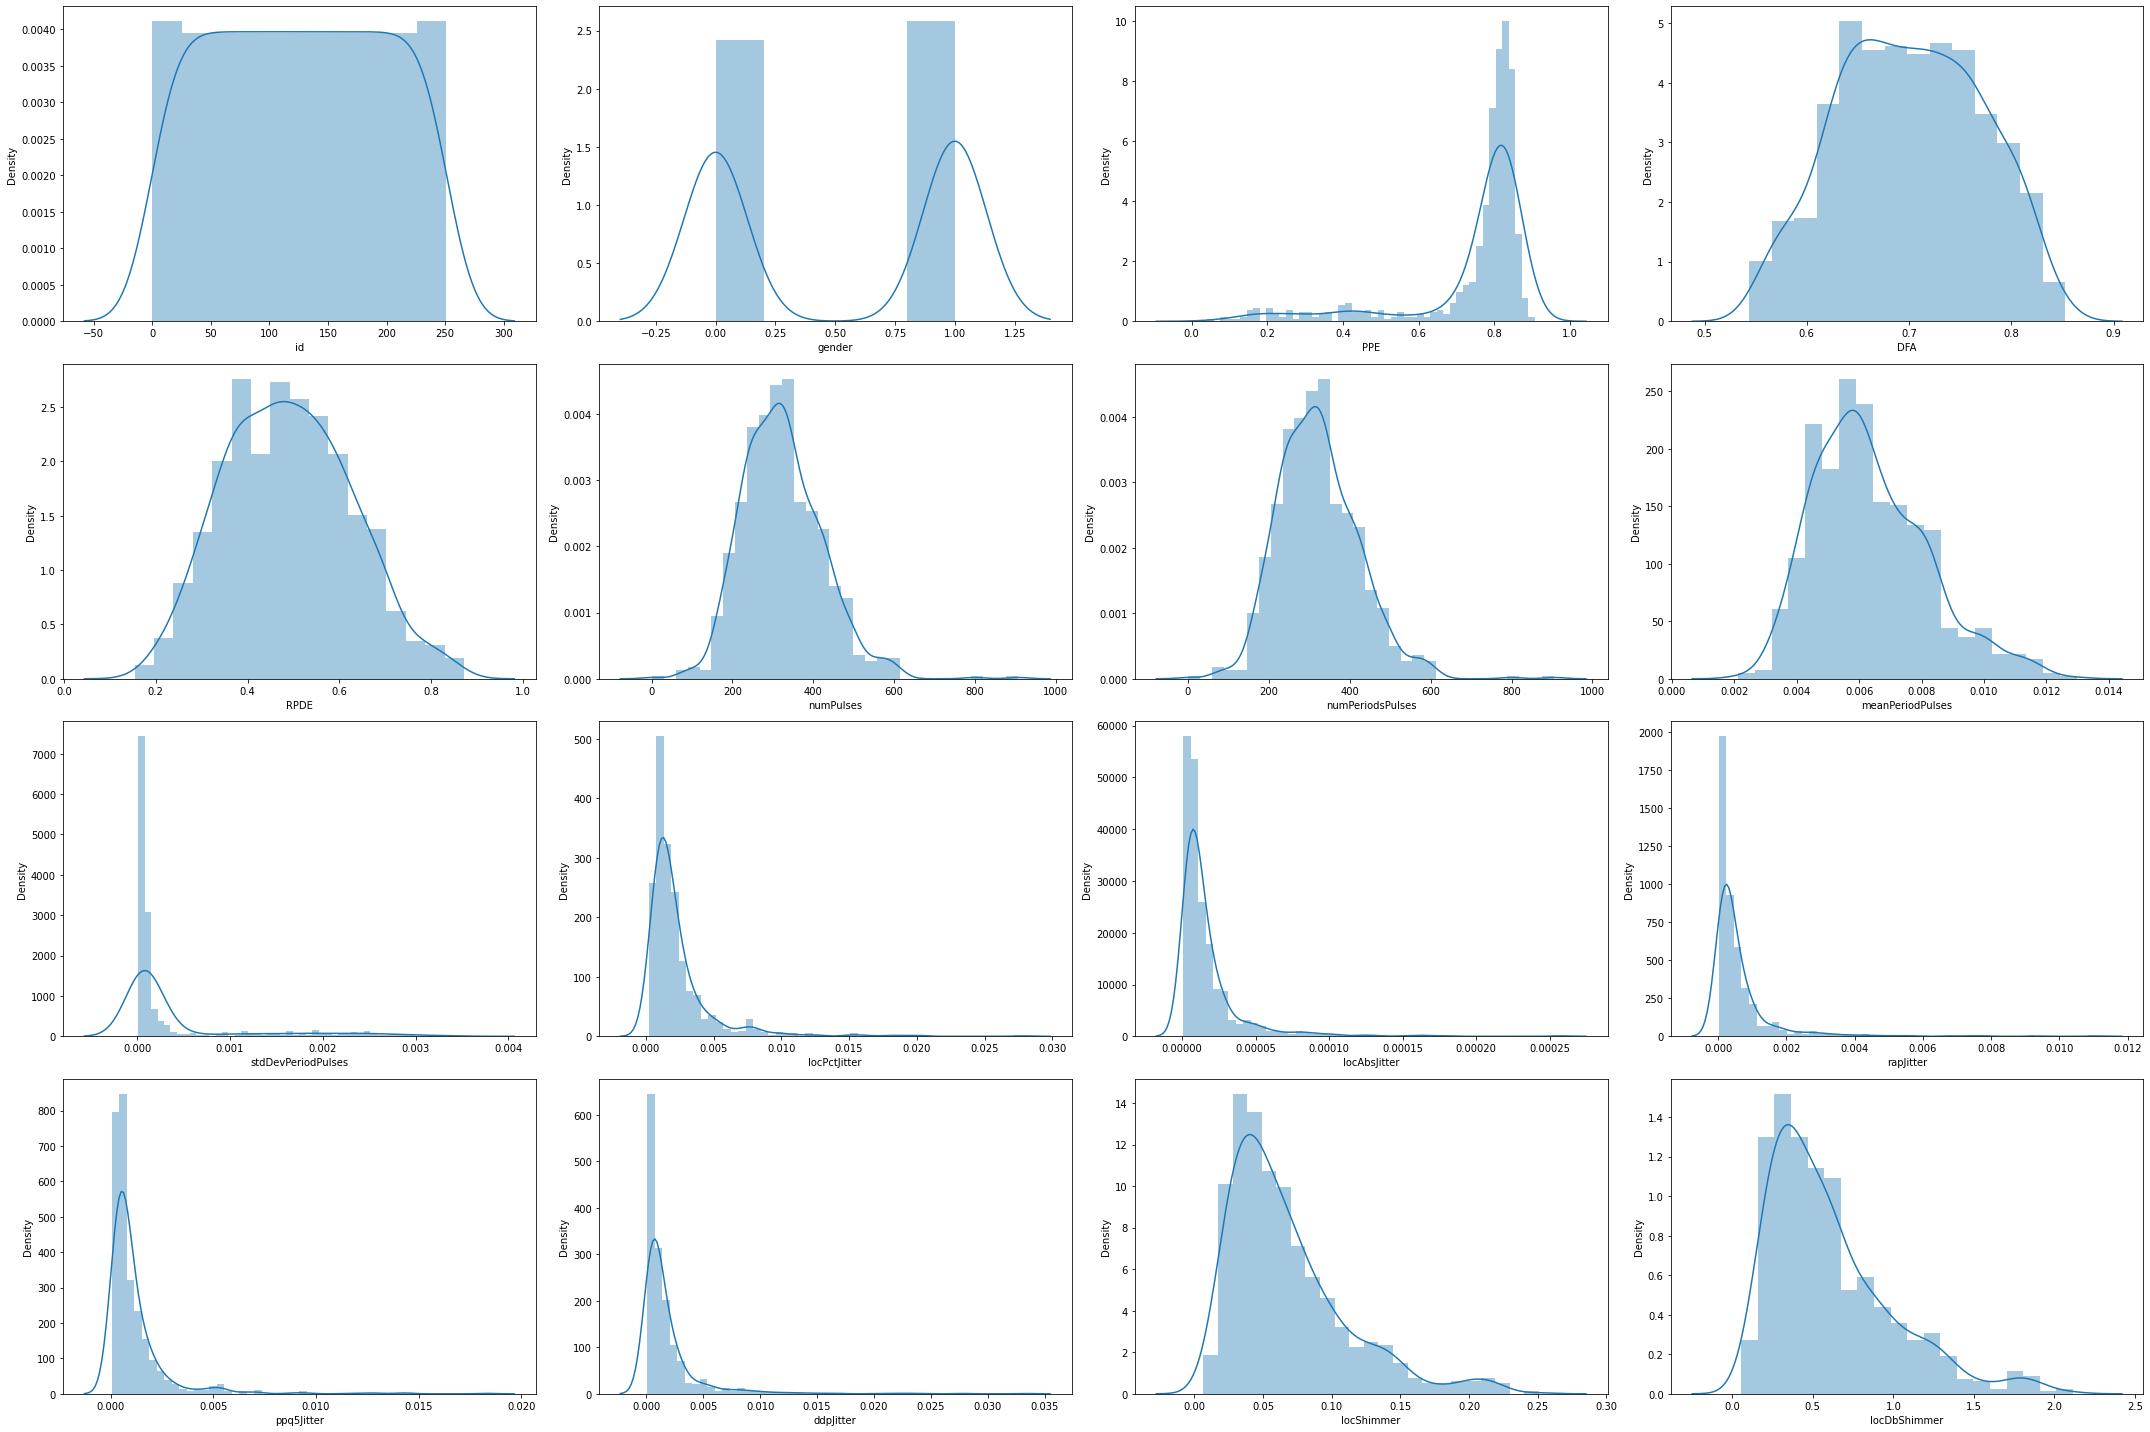

In [ ]:
# distribution of first 16 features
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))
axs = axs.flatten()
index = 0
for k, v in data.items():
  sns.distplot(v, ax=axs[index])
  index += 1
  if index == 16:
    break 
plt.tight_layout()

As we can see in the above output, most of the features have normal distribution, so we should use `StandarScalar` for normalization.

In [ ]:
data['class'].value_counts()

1    564
0    192
Name: class, dtype: int64

As we can see, we have imbalanced data. Most of the patients has parkinson. (1 means the person has parkinson disease and o means rhe person doesn't have parkinson disease.)

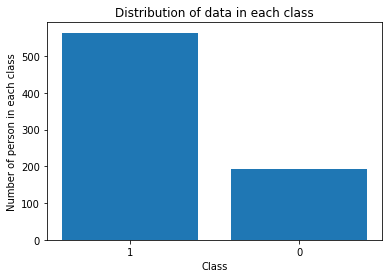

In [ ]:
# distribution of data in each class
distribution = list(data['class'].value_counts())
plt.bar(['1', '0'] ,distribution)
plt.xlabel("Class")
plt.ylabel("Number of person in each class")
plt.title("Distribution of data in each class")
plt.show()

### Drop irrelevant features

Let's remove irrelevant features. In this data we have a column whose name is`id` and it's unique for each person. so we should remove it.

In [4]:
data.drop('id', inplace=True, axis=1)
print(f'data shape : {data.shape}')

data shape : (756, 754)


### Split X and y

In [5]:
X = data.drop(columns='class')
y = pd.DataFrame(data['class'])

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X shape : (756, 753)
y shape : (756, 1)


### Split train and test data set

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (604, 753)
X_test shape: (152, 753)
y_train shape: (604, 1)
y_test shape: (152, 1)


### Standadization


In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## BaseLine model

Let's construct baseline model. Since data with class =1 are more that data with class =0 in our dataset and we have imbalanced dataset, so we can construct baseline model that predicts all of the inputs as class = 1.

In [ ]:
def baseline(X):
  y_pred = []
  for i in range(len(X)):
    y_pred.append(1)
  return y_pred  

In [8]:
def confusion_matrix(y_test, y_pred):
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = [0, 1],
                  columns = [0, 1])
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()  

In [ ]:
y_pred = baseline(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.74      1.00      0.85       113

    accuracy                           0.74       152
   macro avg       0.37      0.50      0.43       152
weighted avg       0.55      0.74      0.63       152



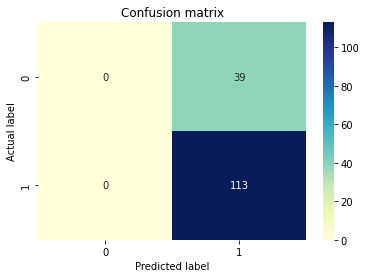

In [ ]:
confusion_matrix(y_test, y_pred)

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier 

criterion = ['gini', 'entropy'] # default=”gini”
splitter = ['best', 'random']
max_depth = [10, 100, 200]

for criteria in criterion:
  for split in splitter:
    for depth in max_depth:

      dt = DecisionTreeClassifier(criterion=criteria, max_depth=depth,splitter=split, random_state=42)
      scores = cross_val_score(dt, X_train, y_train, cv=5)
      print(f'for criterion {criteria}| splitter {split}| depth {depth} : accuracy {scores.mean()}')

for criterion gini| splitter best| depth 10 : accuracy 0.7979889807162535
for criterion gini| splitter best| depth 100 : accuracy 0.7847658402203856
for criterion gini| splitter best| depth 200 : accuracy 0.7847658402203856
for criterion gini| splitter random| depth 10 : accuracy 0.7863498622589532
for criterion gini| splitter random| depth 100 : accuracy 0.7863498622589532
for criterion gini| splitter random| depth 200 : accuracy 0.7863498622589532
for criterion entropy| splitter best| depth 10 : accuracy 0.8261019283746558
for criterion entropy| splitter best| depth 100 : accuracy 0.8327134986225897
for criterion entropy| splitter best| depth 200 : accuracy 0.8327134986225897
for criterion entropy| splitter random| depth 10 : accuracy 0.804504132231405
for criterion entropy| splitter random| depth 100 : accuracy 0.7995454545454546
for criterion entropy| splitter random| depth 200 : accuracy 0.7995454545454546


Till now we have `criterion=entropy, max_depth=100`. Now, we should put best hyperparameters in the model and evaluate them on the test set.

In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth=100, splitter='best',random_state=42)
dt = dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
print(f'10 first elements of y_pred : {y_pred[:10]}')

10 first elements of y_pred : [1 1 1 1 0 1 0 1 1 0]


In [ ]:
print(f'decision tree accuracy on train set: {dt.score(X_train, y_train)}')
print(f'decision tree accuracy on test set : {dt.score(X_test, y_test)}')

decision tree accuracy on train set: 1.0
decision tree accuracy on test set : 0.8223684210526315


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64        39
           1       0.87      0.89      0.88       113

    accuracy                           0.82       152
   macro avg       0.77      0.75      0.76       152
weighted avg       0.82      0.82      0.82       152



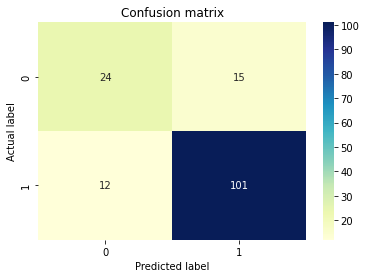

In [ ]:
confusion_matrix(y_test, y_pred)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

criterion = ['gini', 'entropy'] # default=”gini”
n_estimators = [50, 100, 200, 400]
max_depth = [10, 50, 100]

for criteria in criterion:
  for n in n_estimators:
    for depth in max_depth:

      rf = RandomForestClassifier(criterion=criteria, n_estimators=n, max_depth=depth, random_state=42)
      scores = cross_val_score(rf, X_train, y_train, cv=5)
      print(f'criteria :{criteria}| n_estimators {n}| depth : {depth} => accuracy {scores.mean()}')

criteria :gini| n_estimators 50| depth : 10 => accuracy 0.865771349862259
criteria :gini| n_estimators 50| depth : 50 => accuracy 0.8657851239669421
criteria :gini| n_estimators 50| depth : 100 => accuracy 0.8657851239669421
criteria :gini| n_estimators 100| depth : 10 => accuracy 0.8657575757575758
criteria :gini| n_estimators 100| depth : 50 => accuracy 0.8657851239669421
criteria :gini| n_estimators 100| depth : 100 => accuracy 0.8657851239669421
criteria :gini| n_estimators 200| depth : 10 => accuracy 0.8641184573002756
criteria :gini| n_estimators 200| depth : 50 => accuracy 0.8657851239669421
criteria :gini| n_estimators 200| depth : 100 => accuracy 0.8657851239669421
criteria :gini| n_estimators 400| depth : 10 => accuracy 0.8641184573002756
criteria :gini| n_estimators 400| depth : 50 => accuracy 0.8674517906336089
criteria :gini| n_estimators 400| depth : 100 => accuracy 0.8674517906336089
criteria :entropy| n_estimators 50| depth : 10 => accuracy 0.8707851239669422
criteria :

In [ ]:
rf = RandomForestClassifier(criterion = 'entropy', n_estimators=50, max_depth=50, random_state=42)
rf = rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

In [ ]:
print(f'random forest accuracy on train set: {rf.score(X_train, y_train)}')
print(f'random forest accuracy on test set : {rf.score(X_test, y_test)}')

random forest accuracy on train set: 1.0
random forest accuracy on test set : 0.8552631578947368


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.54      0.66        39
           1       0.86      0.96      0.91       113

    accuracy                           0.86       152
   macro avg       0.85      0.75      0.78       152
weighted avg       0.85      0.86      0.84       152



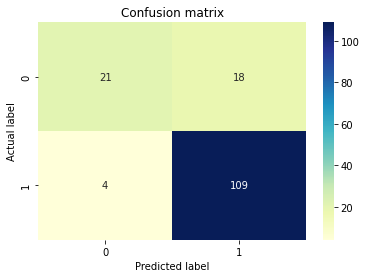

In [ ]:
confusion_matrix(y_test, y_pred)

## XGBoost Classfier

In [ ]:
from xgboost import XGBClassifier

max_depth = [5, 10, 50]
n_estimators = [300, 500]
learning_rate = [0.1, 0.01, 0.001]

for depth in max_depth:
  for n in n_estimators:
    for lr in learning_rate:

      xgb = XGBClassifier(max_depth=depth, n_estimators=n, learning_rate=lr,random_state=42)
      scores = cross_val_score(xgb, X_train, y_train, cv=5)
      print(f'depth: {depth}| n_estimators {n}| lr {lr}  => accuracy {scores.mean()}')

depth: 5| n_estimators 300| lr 0.1  => accuracy 0.8823553719008265
depth: 5| n_estimators 300| lr 0.01  => accuracy 0.8723691460055096
depth: 5| n_estimators 300| lr 0.001  => accuracy 0.8161432506887053
depth: 5| n_estimators 500| lr 0.1  => accuracy 0.8840082644628099
depth: 5| n_estimators 500| lr 0.01  => accuracy 0.8790220385674932
depth: 5| n_estimators 500| lr 0.001  => accuracy 0.8243939393939395
depth: 10| n_estimators 300| lr 0.1  => accuracy 0.8873415977961432
depth: 10| n_estimators 300| lr 0.01  => accuracy 0.8690909090909091
depth: 10| n_estimators 300| lr 0.001  => accuracy 0.8095179063360881
depth: 10| n_estimators 500| lr 0.1  => accuracy 0.8856749311294767
depth: 10| n_estimators 500| lr 0.01  => accuracy 0.8756749311294767
depth: 10| n_estimators 500| lr 0.001  => accuracy 0.8194490358126721
depth: 50| n_estimators 300| lr 0.1  => accuracy 0.8873415977961432
depth: 50| n_estimators 300| lr 0.01  => accuracy 0.8707300275482094
depth: 50| n_estimators 300| lr 0.001  =>

In [ ]:
xgb = XGBClassifier(max_depth=10, n_estimator=300, learning_rate=0.1, random_state=42)
xgb = xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

In [ ]:
print(f'xgb accuracy on train set: {xgb.score(X_train, y_train)}')
print(f'xgb forest accuracy on test set : {xgb.score(X_test, y_test)}')

xgb accuracy on train set: 1.0
xgb forest accuracy on test set : 0.875


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.62      0.72        39
           1       0.88      0.96      0.92       113

    accuracy                           0.88       152
   macro avg       0.87      0.79      0.82       152
weighted avg       0.87      0.88      0.87       152



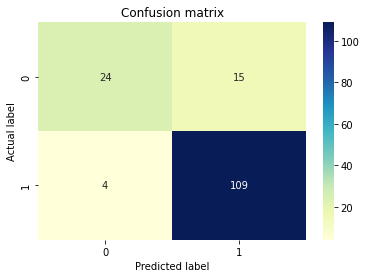

In [ ]:
confusion_matrix(y_test, y_pred)

## SVM Classifier

In [ ]:
from sklearn import svm

kernel = ['linear', 'rbf']

for kernel in kernel:
        
    svc = svm.SVC(kernel=kernel, random_state=42)
    scores = cross_val_score(svc, X_train, y_train, cv=5)
    print(f'kernel : {kernel} => accuracy {scores.mean()}')

kernel : linear => accuracy 0.8161983471074381
kernel : rbf => accuracy 0.8592148760330577


In [ ]:
svc = svm.SVC(kernel='sigmoid', random_state=42)
svc = svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)

In [ ]:
print(f'svc accuracy on train set: {svc.score(X_train, y_train)}')
print(f'svc accuracy on test set : {svc.score(X_test, y_test)}')

svc accuracy on train set: 0.8741721854304636
svc accuracy on test set : 0.8289473684210527


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.51      0.61        39
           1       0.85      0.94      0.89       113

    accuracy                           0.83       152
   macro avg       0.79      0.73      0.75       152
weighted avg       0.82      0.83      0.82       152



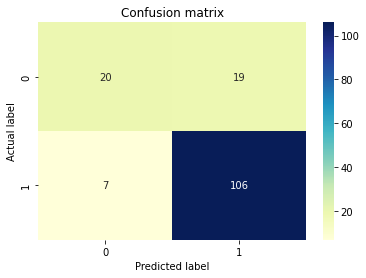

In [ ]:
confusion_matrix(y_test, y_pred)

## Extreme Learning Machine

= a neural network without parameter tuning.

The ELM algorithm is similar to other neural networks with 3 key differences:

1.  The number of hidden units is usually larger than in 
other neural networks that are trained using backpropagation.
2.  The weights from input to hidden layer are randomly generated, usually using values from a continuous uniform distribution.
3.  The output neurons are linear rather than sigmoidal, this means we can use least square errors regression to solve the output weights.



with 20,000 nodes in hidden layer , notebook crashed.

In [ ]:
def hidden_output(x, Win):
  """caculate output of hidden layer"""
  a = np.dot(x, Win)
  a = a + biases
  a = np.maximum(a, 0, a) # ReLUr
  return a

def W_hidden_output(x, y, Win):
  """calculate weight between hidden layer and output"""
  H = hidden_output(x, Win)
  Ht = np.transpose(H)
  Wout = np.dot(np.linalg.inv(np.dot(Ht, H)), np.dot(Ht, y))
  return Wout

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def predict(x, Win, Wout):
  H = hidden_output(x, Win)
  y_pred = np.dot(H, Wout)
  y_pred = sigmoid(y_pred)
  y_pred = np.round(y_pred)
  return y_pred


In [ ]:
input_size = X_train.shape[1]
hidden_neurons = 7000

Win = np.random.normal(size=[input_size, hidden_neurons])
biases = np.random.normal(size=[hidden_neurons])
print(f'biases for hidden layer shape : {biases.shape}')
print(f'weight from input to hidden shape : {Win.shape}')
print(f'10 first element of the first row of Win : \n {Win[0][:10]}')

biases for hidden layer shape : (7000,)
weight from input to hidden shape : (753, 7000)
10 first element of the first row of Win : 
 [ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]


In [ ]:
cv_scores = {'Accuracy': []}
fold = StratifiedKFold(5)

X, y = X_train, y_train

for train_index, valid_index in fold.split(X, y):
    x_train_, x_valid = X[train_index], X[valid_index]
    y_train_, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    Wout = W_hidden_output(x_train_, y_train_, Win)
    y_pred_valid = predict(x_valid, Win, Wout)
    cv_scores['Accuracy'].append(accuracy_score(y_valid, y_pred_valid))

mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}      
print(f"ELM accuracy : {mean_cv_scores['Accuracy']}")

ELM accuracy : 0.46690082644628095


In [ ]:
Wout = W_hidden_output(X_train, y_train, Win)
y_pred_train = predict(X_train, Win, Wout)
y_pred_test = predict(X_test, Win, Wout)

In [ ]:
print(f'elm accuracy on train set: {accuracy_score(y_train, y_pred_train)}')
print(f'elm accuracy on test set : {accuracy_score(y_test, y_pred_test)}')

elm accuracy on train set: 0.4552980132450331
elm accuracy on test set : 0.5328947368421053


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.26      0.44      0.32        39
           1       0.74      0.57      0.64       113

    accuracy                           0.53       152
   macro avg       0.50      0.50      0.48       152
weighted avg       0.62      0.53      0.56       152



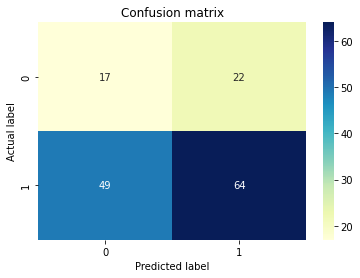

In [ ]:
confusion_matrix(y_test, y_pred_test)

As we can see, this model has a bad result. because it's result is worse than baseline model. The reason is that our model is simpler than our data and can't understand and learn data. we need model with higher complexity or we should use `pca` for dimentionality reduction and the new data can learn using simple model.

## Multi Layer Perceptron

### Prepare data

For MLP we used `Pytorch`. in pytorch we should create class for our dataset then create loader for train and test data and then train the model.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

Let's implement a custom Dataset class.


In [10]:
class ParkinsonData(Dataset):
    def __init__(self, X, y):
        self.n_samples = X.shape[0]
        # convert DataFrame to numpy array
        y = y.to_numpy()
        # convert numpy to tensor
        self.x_data = torch.from_numpy(X.astype(np.float32)) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y.astype(np.float32)) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

Let's pass standarization X_train, X_test, y_train and y_test from EDA part.

In [11]:
# Create data
train_data = ParkinsonData(X_train, y_train)
test_data = ParkinsonData(X_test, y_test)

In [12]:
# get first sample of train data
x_sample, y_sample = train_data[0]
print(f'10 first element of x_sample : \n{x_sample[:10]} \nand y_sample : \n{y_sample}')
print(f'x_sample shape : {x_sample.shape} and y_sample shape : {y_sample}')

10 first element of x_sample : 
tensor([-1.0406,  0.6072, -2.0755, -0.7252,  1.8524,  1.8516, -1.3943, -0.4869,
        -0.6329, -0.6138]) 
and y_sample : 
tensor([1.])
x_sample shape : torch.Size([753]) and y_sample shape : tensor([1.])


Let's create dataloders.

In [13]:
# set parameters
BATCH_SIZE=10
input_size = X.shape[1]
output_size = 1
num_epoch = 4 
learning_rate = 0.001

In [14]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = False) # 
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f'length of train data is : {len(train_data)} and length of train loader is : {len(train_loader)}')
print(f'length of test data is : {len(test_data)} and length of test loader is : {len(test_loader)}')

length of train data is : 604 and length of train loader is : 61
length of test data is : 152 and length of test loader is : 16


In [15]:
# get an example of train loader
example= iter(train_loader)

# unpack example
sample_x,sample_y = example.next()
print(f'samples shape : {sample_x.shape} ,labels shape : {sample_y.shape}')

samples shape : torch.Size([10, 753]) ,labels shape : torch.Size([10, 1])


### Create Model

Let's create a class for our neural network.

In [16]:
# create neural network class
class NeuralNet(nn.Module):
  def __init__(self, input_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc = nn.Sequential(
    nn.Linear(input_size, 100),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid())

  def forward(self,x):
    out = self.fc(x)
    return out

Let's define necessary functions.

In [17]:
# define a function to calculate accuracy
def accuracy(y_pred, y_act):
  y_pred = torch.round(y_pred)
  correct = (y_pred == y_act)
  acc = correct.sum()/len(correct)
  acc = torch.round(acc*100)
  return acc

# define a function for training a model
def train_fun(model1, train_loader):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model1.train() # train the model
  loop = tqdm(enumerate(train_loader), total = total_step, leave = False)

  for i, batch in loop:
    optimizer.zero_grad()
    x, y = batch # retrieve x and y
    x = x.to(device)
    y = y.to(device)
    y_pred = model1(x)
    loss_train = criterion(y_pred, y)
    acc_train = accuracy(y_pred, y)
    loss_train.backward()
    optimizer.step()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()
    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  # if you want to monitor your model in tensorboard   
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)
  return train_loss, train_acc

# define a function for evaluating model
def evaluate(model1, valid_loader):
  with torch.no_grad():
    model1.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0

    for batch in valid_loader:
      x, y = batch
      x = x.to(device)
      y = y.to(device)
      y_pred_val = model1(x)
      loss_valid = criterion(y_pred_val, y)
      acc_valid = accuracy(y_pred_val, y) 
      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader))  

    writer.add_scalar('validation loss',val_epoch_loss/len(valid_loader) , epoch)
    writer.add_scalar('validation accuracy',val_epoch_acc/len(valid_loader) , epoch)
  return valid_loss, valid_acc

# define a function for evaluating model on test set
def test(model1, test_loader):
  y_pred_test = []
  y_actual_test = []

  model1.eval()
  with torch.no_grad():
    n_true = 0
    n_total = 0
    n_class_correct = [0 for i in range(num_class)]
    n_class_sample = [0 for i in range(num_class)]
  
    for batch in test_loader:
      x, y = batch
      output = model1(x)
      y_predtest = torch.round(output)
      n_true += (y_predtest == y).sum()
      n_total += y.size(0)

      for i in range(len(y_predtest)):
        y_pred_test.append(y_predtest[i])
        y_actual_test.append(y[i].item())

      for i in range(len(y_predtest)):
        lb = int(y[i].item())
        pred = y_predtest[i]
        if pred == lb:
          n_class_correct[lb] += 1
        n_class_sample[lb] += 1   

    print(f'accuracy of network on the {len(test_loader)} data is : {(n_true/n_total) *100}')
  
    for i in range(len(classes)):
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {classes[i]}: {acc} %')
  
  return y_pred_test, y_actual_test  

### Parameter tuning using Cross validation 

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('parkinson')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir 'parkinson'

In [20]:
fold = StratifiedKFold(5) # shuffle false because we shuffled data in splitting train and test section
cv_scores = {'Accuracy' : []}

for fold, (train_ids, valid_ids) in enumerate(fold.split(X_train, y_train)):
  # sample elements randomly from a give list of ids, no replacement
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

  # create dataloader for train and valid data in this fold
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_subsampler)
  validloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_subsampler)

  model = NeuralNet(input_size, output_size)
  optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
  criterion = nn.BCELoss()
  scheduler = lr_scheduler.StepLR(optimizer, 3, gamma=0.5)

  total_step = len(trainloader)
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epoch):
    train_loss, train_acc = train_fun(model, trainloader)
    writer.flush() 
    valid_loss, valid_acc = evaluate(model, validloader)   
    print(f'fold {fold} => train acc : {train_acc[-1]:0.2f}| train loss : {train_loss[-1]:0.2f}| valid acc : {valid_acc[-1]:0.2f}| valid loss : {valid_loss[-1]:0.2f}')
    scheduler.step()

  cv_scores['Accuracy'].append(valid_acc[-1])


fold 0 => train acc : 73.47| train loss : 0.55| valid acc : 89.23| valid loss : 0.32


fold 0 => train acc : 84.69| train loss : 0.40| valid acc : 92.31| valid loss : 0.25


fold 0 => train acc : 88.16| train loss : 0.29| valid acc : 88.46| valid loss : 0.21


fold 0 => train acc : 88.92| train loss : 0.27| valid acc : 90.77| valid loss : 0.19


fold 1 => train acc : 72.59| train loss : 0.54| valid acc : 87.69| valid loss : 0.42


fold 1 => train acc : 85.31| train loss : 0.34| valid acc : 87.69| valid loss : 0.33


fold 1 => train acc : 89.59| train loss : 0.27| valid acc : 87.69| valid loss : 0.31


fold 1 => train acc : 91.84| train loss : 0.21| valid acc : 89.23| valid loss : 0.28


fold 2 => train acc : 77.00| train loss : 0.51| valid acc : 86.15| valid loss : 0.39


fold 2 => train acc : 85.92| train loss : 0.36| valid acc : 86.15| valid loss : 0.35


fold 2 => train acc : 87.90| train loss : 0.30| valid acc : 91.54| valid loss : 0.30


fold 2 => train acc : 90.41| train loss : 0.22| valid acc : 92.31| valid loss : 0.26


fold 3 => train acc : 76.12| train loss : 0.51| valid acc : 80.00| valid loss : 0.43


fold 3 => train acc : 87.14| train loss : 0.36| valid acc : 83.85| valid loss : 0.39


fold 3 => train acc : 88.78| train loss : 0.28| valid acc : 83.85| valid loss : 0.36


fold 3 => train acc : 92.04| train loss : 0.22| valid acc : 83.08| valid loss : 0.35


fold 4 => train acc : 80.31| train loss : 0.49| valid acc : 80.83| valid loss : 0.49


fold 4 => train acc : 86.94| train loss : 0.32| valid acc : 81.67| valid loss : 0.42


fold 4 => train acc : 89.59| train loss : 0.26| valid acc : 78.33| valid loss : 0.43


fold 4 => train acc : 92.96| train loss : 0.19| valid acc : 80.83| valid loss : 0.45


In [21]:
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}  
print(f"mean accuracy using 5 foldCV : {mean_cv_scores['Accuracy']:0.2f}")

mean accuracy using 5 foldCV : 87.24


### Train the model

After tune parameters uning kfold cross validation we should train a model with these parameters and test it.

In [22]:
# create model
model = NeuralNet(input_size, output_size)

# create loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 3, gamma=0.5)
total_step = len(train_loader)

In [23]:
model

NeuralNet(
  (fc): Sequential(
    (0): Linear(in_features=753, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Let's train our model.

In [24]:
train_loss, train_acc  = [], []

for epoch in range(num_epoch):
  train_loss, train_acc = train_fun(model, train_loader)
  writer.flush()   
  scheduler.step()

In [ ]:
torch.save(model, '/content/drive/MyDrive/ML_Dr.sajedi/mlp') # model1 with 10 epochs

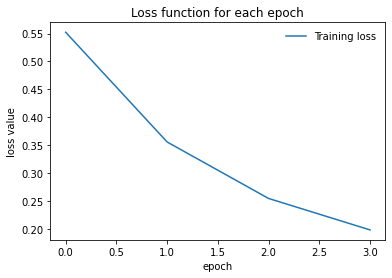

In [25]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()


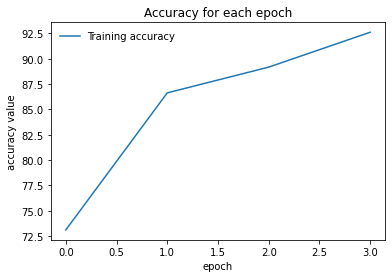

In [26]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

In [27]:
print(f'training loss on last epoch : {train_loss[-1]}')
# print(f'validation loss on last epoch : {valid_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')
# print(f'validation accuracy on last epoch : {valid_acc[-1]}')

training loss on last epoch : 0.19836874080241704
--------------------
training accuracy on last epoch : 92.62295081967213


### Test the model

In [28]:
num_class =2
classes = ['0', '1']

y_pred_test, y_actual_test = test(model, test_loader)

accuracy of network on the 16 data is : 84.21052551269531
Accuracy of 0: 58.97435897435897 %
Accuracy of 1: 92.92035398230088 %


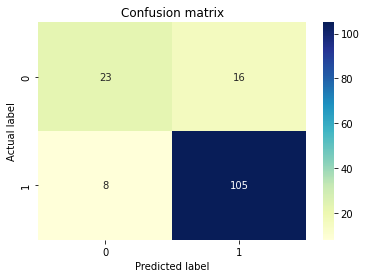

In [29]:
confusion_matrix(y_actual_test, y_pred_test)

In [30]:
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.74      0.59      0.66        39
         1.0       0.87      0.93      0.90       113

    accuracy                           0.84       152
   macro avg       0.80      0.76      0.78       152
weighted avg       0.84      0.84      0.84       152



## Autoencoder

### Create Model

In this section we use train and test loader from previous section.

In [ ]:
# 753 ==> 9 ==> 753 
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Create linear encoder with Linear layer followed by Relu activation function
        self.encoder = nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
          
        # Create linear decoder with Linear layer followed by Relu activation function
        self.decoder = nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size),
            torch.nn.ReLU()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

Because we return two values in forward function we should change train, evaluate and test function a little. In autoencoders we don't need accuracy.

In [ ]:
# define a function for training a model
def train_ae(model1, train_loader):
  train_epoch_loss = 0
  model1.train() # train the model
  loop = tqdm(enumerate(train_loader), total = total_step, leave = False)

  for i, batch in loop:
    optimizer.zero_grad()
    x, y = batch # retrieve x and y
    x = x.to(device)
    _, x_pred = model1(x)
    loss_train = criterion(x_pred, x)
    loss_train.backward()
    optimizer.step()

    train_epoch_loss += loss_train.item()
    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader)) 
      
  # if you want to monitor your model in tensorboard   
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  return train_loss

# define a function for evaluating model
def evaluate_ae(model1, valid_loader):
  with torch.no_grad():
    model1.eval()
    val_epoch_loss = 0

    for batch in valid_loader:
      x, y = batch
      x = x.to(device)
      _, x_pred_val = model1(x)
      loss_valid = criterion(x_pred_val, x)
      val_epoch_loss += loss_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader)) 

    writer.add_scalar('validation loss',val_epoch_loss/len(valid_loader) , epoch)
  return valid_loss

### Parameter tuning using Cross validation

In [ ]:
input_size = X.shape[1]
num_epoch = 2
learning_rate = 0.01

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('parkinson_ae')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir 'parkinson_ae'

In [ ]:
fold = StratifiedKFold(5) # shuffle false because we shuffled data in splitting train and test section

for fold, (train_ids, valid_ids) in enumerate(fold.split(X_train, y_train)):
  # sample elements randomly from a give list of ids, no replacement
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

  # create dataloader for train and valid data in this fold
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_subsampler)
  validloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_subsampler)

  model = Autoencoder(input_size)
  optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
  criterion = nn.MSELoss()
  scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.7)

  total_step = len(trainloader)
  train_loss, valid_loss = [], []

  for epoch in range(num_epoch):
    train_loss = train_ae(model, trainloader)
    writer.flush() 
    valid_loss = evaluate_ae(model, validloader)   
    print(f'fold {fold} => train loss : {train_loss[-1]:0.2f}| valid loss : {valid_loss[-1]:0.2f}')
    scheduler.step()

fold 0 => train loss : 0.94| valid loss : 1.05


fold 0 => train loss : 0.92| valid loss : 1.04


fold 1 => train loss : 0.97| valid loss : 1.04


fold 1 => train loss : 0.96| valid loss : 1.14


fold 2 => train loss : 1.02| valid loss : 0.84


fold 2 => train loss : 1.01| valid loss : 0.83


fold 3 => train loss : 0.98| valid loss : 0.95


fold 3 => train loss : 0.96| valid loss : 0.96


fold 4 => train loss : 0.99| valid loss : 0.89


fold 4 => train loss : 0.98| valid loss : 0.88


In [ ]:
# create model
model = Autoencoder(input_size)

# create loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.7)
total_step = len(train_loader)

In [ ]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=753, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=753, bias=True)
    (9): ReLU()
  )
)

### Train the model

Let's test the model.

In [ ]:
train_loss = []

for epoch in range(num_epoch):
  train_loss = train_ae(model, train_loader)
  writer.flush()   
  scheduler.step()

In [ ]:
train_loss

[0.9790549732622553, 0.9647887779063866]

### How about test the mdoel????????? for the ae part

let's save the best model.

In [ ]:
PATH = "autoencoder.pt"
# Save
torch.save(model.state_dict(), PATH)

In [ ]:
# model.state_dict()

### Autoencoder feature extraction for classification

Let's load the pretrained autoencoder to use it for classification.

In [ ]:
AE = Autoencoder(input_size)
AE.load_state_dict(torch.load('/content/drive/MyDrive/ML_Dr.sajedi/autoencoder.pt'))

<All keys matched successfully>

#### Create classification part

In [ ]:
class Classification_MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.AE = Autoencoder(input_size)
        self.AE.load_state_dict(torch.load('/content/drive/MyDrive/ML_Dr.sajedi/autoencoder.pt'))
        self.classifier = nn.Sequential(nn.Linear(9,1), nn.Sigmoid())

    def forward(self, input):
        encoded, decoded = self.AE(input)
        output = self.classifier(encoded)
        return output

#### Parameter tuning for classifier using Cross Validation

Let's evaluate out model using Kfold CV.

In [ ]:
fold = StratifiedKFold(5) # shuffle false because we shuffled data in splitting train and test section
cv_scores = {'Accuracy' : []}

for fold, (train_ids, valid_ids) in enumerate(fold.split(X_train, y_train)):
  # sample elements randomly from a give list of ids, no replacement
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

  # create dataloader for train and valid data in this fold
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_subsampler)
  validloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_subsampler)

  model = Classification_MLP(input_size)
  optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
  criterion = nn.BCELoss()
  scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.7)

  total_step = len(trainloader)
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epoch):
    train_loss, train_acc = train_fun(model, trainloader)
    writer.flush() 
    valid_loss, valid_acc = evaluate(model, validloader)   
    print(f'fold {fold} => train acc : {train_acc[-1]:0.2f}| train loss : {train_loss[-1]:0.2f}| valid acc : {valid_acc[-1]:0.2f}| valid loss : {valid_loss[-1]:0.2f}')
    scheduler.step()

  cv_scores['Accuracy'].append(valid_acc[-1])


fold 0 => train acc : 74.29| train loss : 0.58| valid acc : 83.08| valid loss : 0.34


fold 0 => train acc : 82.45| train loss : 0.41| valid acc : 88.46| valid loss : 0.25


fold 1 => train acc : 79.59| train loss : 0.51| valid acc : 83.85| valid loss : 0.38


fold 1 => train acc : 87.14| train loss : 0.32| valid acc : 87.69| valid loss : 0.31


fold 2 => train acc : 70.82| train loss : 0.51| valid acc : 76.15| valid loss : 0.41


fold 2 => train acc : 79.33| train loss : 0.41| valid acc : 83.08| valid loss : 0.43


fold 3 => train acc : 70.00| train loss : 0.60| valid acc : 69.23| valid loss : 0.52


fold 3 => train acc : 79.86| train loss : 0.42| valid acc : 77.69| valid loss : 0.49


fold 4 => train acc : 74.80| train loss : 1.12| valid acc : 78.33| valid loss : 0.49


fold 4 => train acc : 85.71| train loss : 0.36| valid acc : 82.50| valid loss : 0.46


In [ ]:
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}  
print(f"mean accuracy using 5 foldCV : {mean_cv_scores['Accuracy']:0.2f}")

mean accuracy using 5 foldCV : 83.88


#### Train the model (AE + Classifier)

In [ ]:
# create model
ae_mlp = Classification_MLP(input_size)

# create loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(ae_mlp.parameters(), lr= learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.7)
total_step = len(train_loader)

In [ ]:
ae_mlp

Classification_MLP(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=753, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=36, bias=True)
      (5): ReLU()
      (6): Linear(in_features=36, out_features=18, bias=True)
      (7): ReLU()
      (8): Linear(in_features=18, out_features=9, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=9, out_features=18, bias=True)
      (1): ReLU()
      (2): Linear(in_features=18, out_features=36, bias=True)
      (3): ReLU()
      (4): Linear(in_features=36, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=753, bias=True)
      (9): ReLU()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=9, out_features=1, bias=True)
    (1): Sigmoid(

In [ ]:
train_loss, train_acc  = [], []

for epoch in range(num_epoch):
  train_loss, train_acc = train_fun(ae_mlp, train_loader)
  writer.flush()   
  scheduler.step()

In [ ]:
torch.save(model, '/content/drive/MyDrive/ML_Dr.sajedi/ae_mlp') # model1 with 10 epochs

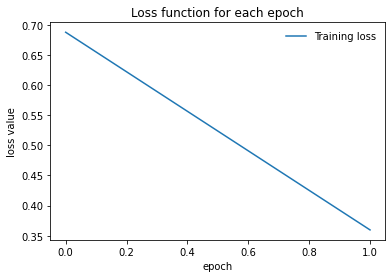

In [ ]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
# plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()


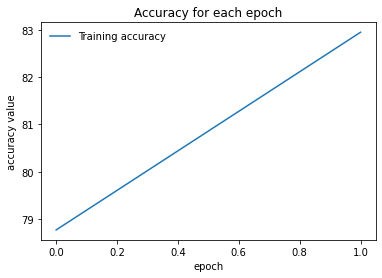

In [ ]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
# plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

In [ ]:
print(f'training loss on last epoch : {train_loss[-1]}')
# print(f'validation loss on last epoch : {valid_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')
# print(f'validation accuracy on last epoch : {valid_acc[-1]}')

training loss on last epoch : 0.35961004688602977
--------------------
training accuracy on last epoch : 82.95081967213115


#### Test the model

In [ ]:
y_pred_test, y_actual_test = test(ae_mlp, test_loader)

accuracy of network on the 16 data is : 80.92105102539062
Accuracy of 0: 61.53846153846154 %
Accuracy of 1: 87.61061946902655 %


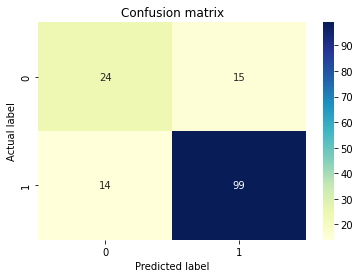

In [ ]:
confusion_matrix(y_actual_test, y_pred_test)

In [ ]:
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.63      0.62      0.62        39
         1.0       0.87      0.88      0.87       113

    accuracy                           0.81       152
   macro avg       0.75      0.75      0.75       152
weighted avg       0.81      0.81      0.81       152



In [ ]:
print(train_subsampler)

In [ ]:
len(trainloader)

49

In [ ]:
len(validloader)

12